# Motion Prediction EDA

This project uses synthetic generated data from https://infinity.ai/ \
The data sets can be downloaded directly from the above site, and there is too much to add to this repository.

Github https://github.com/toinfinityai/infinity-datasets/tree/main 



#### Parameters
num_reps:  Number of exercise repetitions in the returned time series data.\
watch_location:  Wrist where device is placed (left or right).\
crown_orientation:  Which side the watch crown points (from first-person perspective; left or right).\
ref_xy_rotation:  Rotation (in XY plane) of the reference orientation in radians (simulates the xArbitraryZVertical reference in the Apple CoreMotion SDK).\
rel_baseline_speed:  Baseline speed of animation, relative to default (natural) speed.\
max_rel_speed_change:  Maximum speed change introduced, relative to baseline speed.\
trim_start_frac:  Fraction of seed animation (from start to midpoint) to truncate at the start.\
trim_end_frac:  Fraction of seed animation (from start to midpoint) to truncate at the end.\
kinematic_noise_factor:  Scaling factor used to adjust the amount of kinematic noise added in the simulated movement.\
wrist_offset_deg:  Fixed rotation offset applied to the supination/pronation axis of the wrists, in degrees. Negative values correspond to supination.\
randomize_body_shape:  If True, the avatar's body shape is randomized.\
frames_per_second:  Sampling rate of exported time series and video.\
image_width:  Width dimension of the rendered video, in pixels.\
image_height:  Height dimension of the rendered video, in pixels.


In [1]:
# Libraries used

import pandas as pd
import numpy as np
import glob
import json
from pandas import json_normalize
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# code to toggle how much of the columns and rows that can be seen

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) 
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

There are 2000 csv files containing rotation matrices for the various exercises and corresponding json files with the parameters used to obtaining the data. The following function retrieves both files and merges them into one dataframe per csv file. Also added some feature engineering and created a column numbering the reps in each csv file and adding an average time per rep.

In [11]:
# function for retrieving multiple csv/json files

def create_combined_dataframe(directory, keep_csv_ref_xy_rotation=True):
    """
    Create a combined DataFrame for each set of CSV and JSON files in the specified directory. Add a 'rep_num' and 'avg_rep_time' column to DataFrames

    Parameters:
    - directory (str): The directory containing CSV and JSON files.
    - keep_csv_ref_xy_rotation (bool): True to keep the 'ref_xy_rotation' column from the CSV file, False to keep it from the JSON file.

    Returns:
    - List[pd.DataFrame]: A list of DataFrames where each DataFrame combines CSV and JSON data, with each parameter in the JSON file having its own column.
    """
    combined_dfs = []
    
    # creates list of file names matching the pattern '*.csv' in the specified directory
    csv_files = glob.glob(f'{directory}/*.csv')

    # accessing csv files
    for csv_file in csv_files:
        csv_df = pd.read_csv(csv_file, index_col=0)
        
        # creating column assigning rep numbers
        csv_df['rep_num'] = np.floor(csv_df['rep_count_from_start'] + 1).astype(int)
        
        # creating column with average rep time
        csv_df['avg_rep_time'] = csv_df['time'].max() / csv_df['rep_num'].max()

        # accessing json files
        json_file = os.path.splitext(csv_file)[0] + '_params.json'
        with open(json_file, 'r') as f:
            json_data = json.load(f)

        json_df = json_normalize(json_data)
        json_df.columns = [col.replace('params.', '') for col in json_df.columns]
        json_df = pd.concat([json_df] * len(csv_df), ignore_index=True)

        # Choose which 'ref_xy_rotation' column to keep
        if keep_csv_ref_xy_rotation:
            combined_df = pd.concat([json_df, csv_df.drop('ref_xy_rotation', axis=1)], axis=1)
        else:
            combined_df = pd.concat([json_df.drop('ref_xy_rotation', axis=1), csv_df], axis=1)

        combined_dfs.append(combined_df)

    return combined_dfs


In [9]:
# creating list of dataframes for all exercises

armraise_path = '../data/basic_motions/armraise'
armraise_dataframes = create_combined_dataframe(armraise_path)

bicepcurl_path = '../data/basic_motions/bicepcurl'
bicepcurl_dataframes = create_combined_dataframe(bicepcurl_path)

birddog_path = '../data/basic_motions/birddog'
birddog_dataframes = create_combined_dataframe(birddog_path)

burpee_path = '../data/basic_motions/burpee'
burpee_dataframes = create_combined_dataframe(burpee_path)

crunch_path = '../data/basic_motions/crunch'
crunch_dataframes = create_combined_dataframe(crunch_path)

hammercurl_path = '../data/basic_motions/hammercurl'
hammercurl_dataframes = create_combined_dataframe(hammercurl_path)

overheadpress_path = '../data/basic_motions/overheadpress'
overheadpress_dataframes = create_combined_dataframe(overheadpress_path)

pushup_path = '../data/basic_motions/pushup'
pushup_dataframes = create_combined_dataframe(pushup_path)

tricepkickback_left_path = '../data/basic_motions/tricepkickback_left'
tricepkickback_left_dataframes = create_combined_dataframe(tricepkickback_left_path)

tricepkickback_right_path = '../data/basic_motions/tricepkickback_right'
tricepkickback_right_dataframes = create_combined_dataframe(tricepkickback_right_path)

vup_path = '../data/basic_motions/vup'
vup_dataframes = create_combined_dataframe(vup_path)

In [10]:
# viewing the inital data set up

armraise_dataframes[0]

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,time,rotation_matrix_m11,rotation_matrix_m12,rotation_matrix_m13,rotation_matrix_m21,rotation_matrix_m22,rotation_matrix_m23,rotation_matrix_m31,rotation_matrix_m32,rotation_matrix_m33,rep_num,avg_rep_time
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,0.00,0.313452,-0.218860,-0.924039,0.097586,0.975350,-0.197910,0.944576,-0.028138,0.327084,1,2.970833
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,0.05,0.319075,-0.216120,-0.922758,0.092488,0.976105,-0.196634,0.943206,-0.022603,0.331439,1,2.970833
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,0.10,0.331619,-0.214452,-0.918716,0.085394,0.976647,-0.197151,0.939541,-0.013074,0.342188,1,2.970833
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.523469,0.049785,0.15,0.350453,-0.213280,-0.911973,0.077130,0.976991,-0.198847,0.933399,-0.000654,0.358839,1,2.970833
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.540063,0.066379,0.20,0.379883,-0.213341,-0.900097,0.067529,0.976841,-0.203030,0.922566,0.016345,0.385492,1,2.970833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.370983,11.897299,35.45,0.515902,-0.055648,-0.854838,-0.001645,0.997822,-0.065948,0.856646,0.035429,0.514687,12,2.970833
710,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.387749,11.914065,35.50,0.458979,-0.059240,-0.886470,0.014939,0.998148,-0.058968,0.888321,0.013822,0.459014,12,2.970833
711,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.404509,11.930825,35.55,0.416546,-0.063375,-0.906903,0.030470,0.997980,-0.055744,0.908604,-0.004413,0.417636,12,2.970833
712,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.421261,11.947576,35.60,0.383611,-0.067923,-0.920994,0.048168,0.997406,-0.053496,0.922238,-0.023840,0.385887,12,2.970833


In [84]:
armraise_dataframes[0].shape

(714, 34)

In [12]:
# function for saving datasets

import pickle

def save_dataframes(list_of_dataframe_lists, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(list_of_dataframe_lists, file)

In [13]:
all_lists = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]
file_path = "D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\dataframes_no_processing.pkl"

save_dataframes(all_lists, file_path)


## Learning about changing rotational transformation matrix to roll-pitch-yaw

By converting the rotation matrices to roll-pitch-yaw I can reduce the matrix values in each row from 9 to 3 and reduce the size of the over all set.

Some sources that I looked at while starting this next part.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_euler.html \
https://eigen.tuxfamily.org/dox/group__Geometry__Module.html#title40 \
https://github.com/zivid/zivid-python-samples/blob/master/source/applications/advanced/hand_eye_calibration/pose_conversions.py 

In [15]:
# fuction to convert the rotation matrices to euler angles

from scipy.spatial.transform import Rotation as R

def add_euler_columns(df):
    rotation_matrix_columns = [
        'rotation_matrix_m11', 'rotation_matrix_m12', 'rotation_matrix_m13',
        'rotation_matrix_m21', 'rotation_matrix_m22', 'rotation_matrix_m23',
        'rotation_matrix_m31', 'rotation_matrix_m32', 'rotation_matrix_m33'
    ]

    rotation_matrices = df[rotation_matrix_columns].values.reshape(-1, 3, 3)
    euler_angles = R.from_matrix(rotation_matrices).as_euler("xyz")

    euler_df = pd.DataFrame(euler_angles, columns=['euler_x', 'euler_y', 'euler_z'])
    
    
    df = df.drop(rotation_matrix_columns, axis=1)
    df = pd.concat([df, euler_df], axis=1)

    return df

In [16]:
# Updating each DataFrame in the list with euler angles instead of rotation matrix

for i in range(len(armraise_dataframes)):
    armraise_dataframes[i] = add_euler_columns(armraise_dataframes[i])

for i in range(len(bicepcurl_dataframes)):
    bicepcurl_dataframes[i] = add_euler_columns(bicepcurl_dataframes[i])
    
for i in range(len(birddog_dataframes)):
    birddog_dataframes[i] = add_euler_columns(birddog_dataframes[i])
    
for i in range(len(burpee_dataframes)):
    burpee_dataframes[i] = add_euler_columns(burpee_dataframes[i])

for i in range(len(crunch_dataframes)):
    crunch_dataframes[i] = add_euler_columns(crunch_dataframes[i])
    
for i in range(len(hammercurl_dataframes)):
    hammercurl_dataframes[i] = add_euler_columns(hammercurl_dataframes[i])
    
for i in range(len(overheadpress_dataframes)):
    overheadpress_dataframes[i] = add_euler_columns(overheadpress_dataframes[i])
    
for i in range(len(pushup_dataframes)):
    pushup_dataframes[i] = add_euler_columns(pushup_dataframes[i])
    
for i in range(len(tricepkickback_left_dataframes)):
    tricepkickback_left_dataframes[i] = add_euler_columns(tricepkickback_left_dataframes[i])
    
for i in range(len(tricepkickback_right_dataframes)):
    tricepkickback_right_dataframes[i] = add_euler_columns(tricepkickback_right_dataframes[i])
    
for i in range(len(vup_dataframes)):
    vup_dataframes[i] = add_euler_columns(vup_dataframes[i])

In [17]:
# looking at dataframe

armraise_dataframes[0].head(3)

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,time,rep_num,avg_rep_time,euler_x,euler_y,euler_z
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,0.00,1,2.970833,-0.085816,-1.236302,0.301816
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,0.05,1,2.970833,-0.068092,-1.232152,0.282132
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,0.10,1,2.970833,-0.038189,-1.221286,0.252032


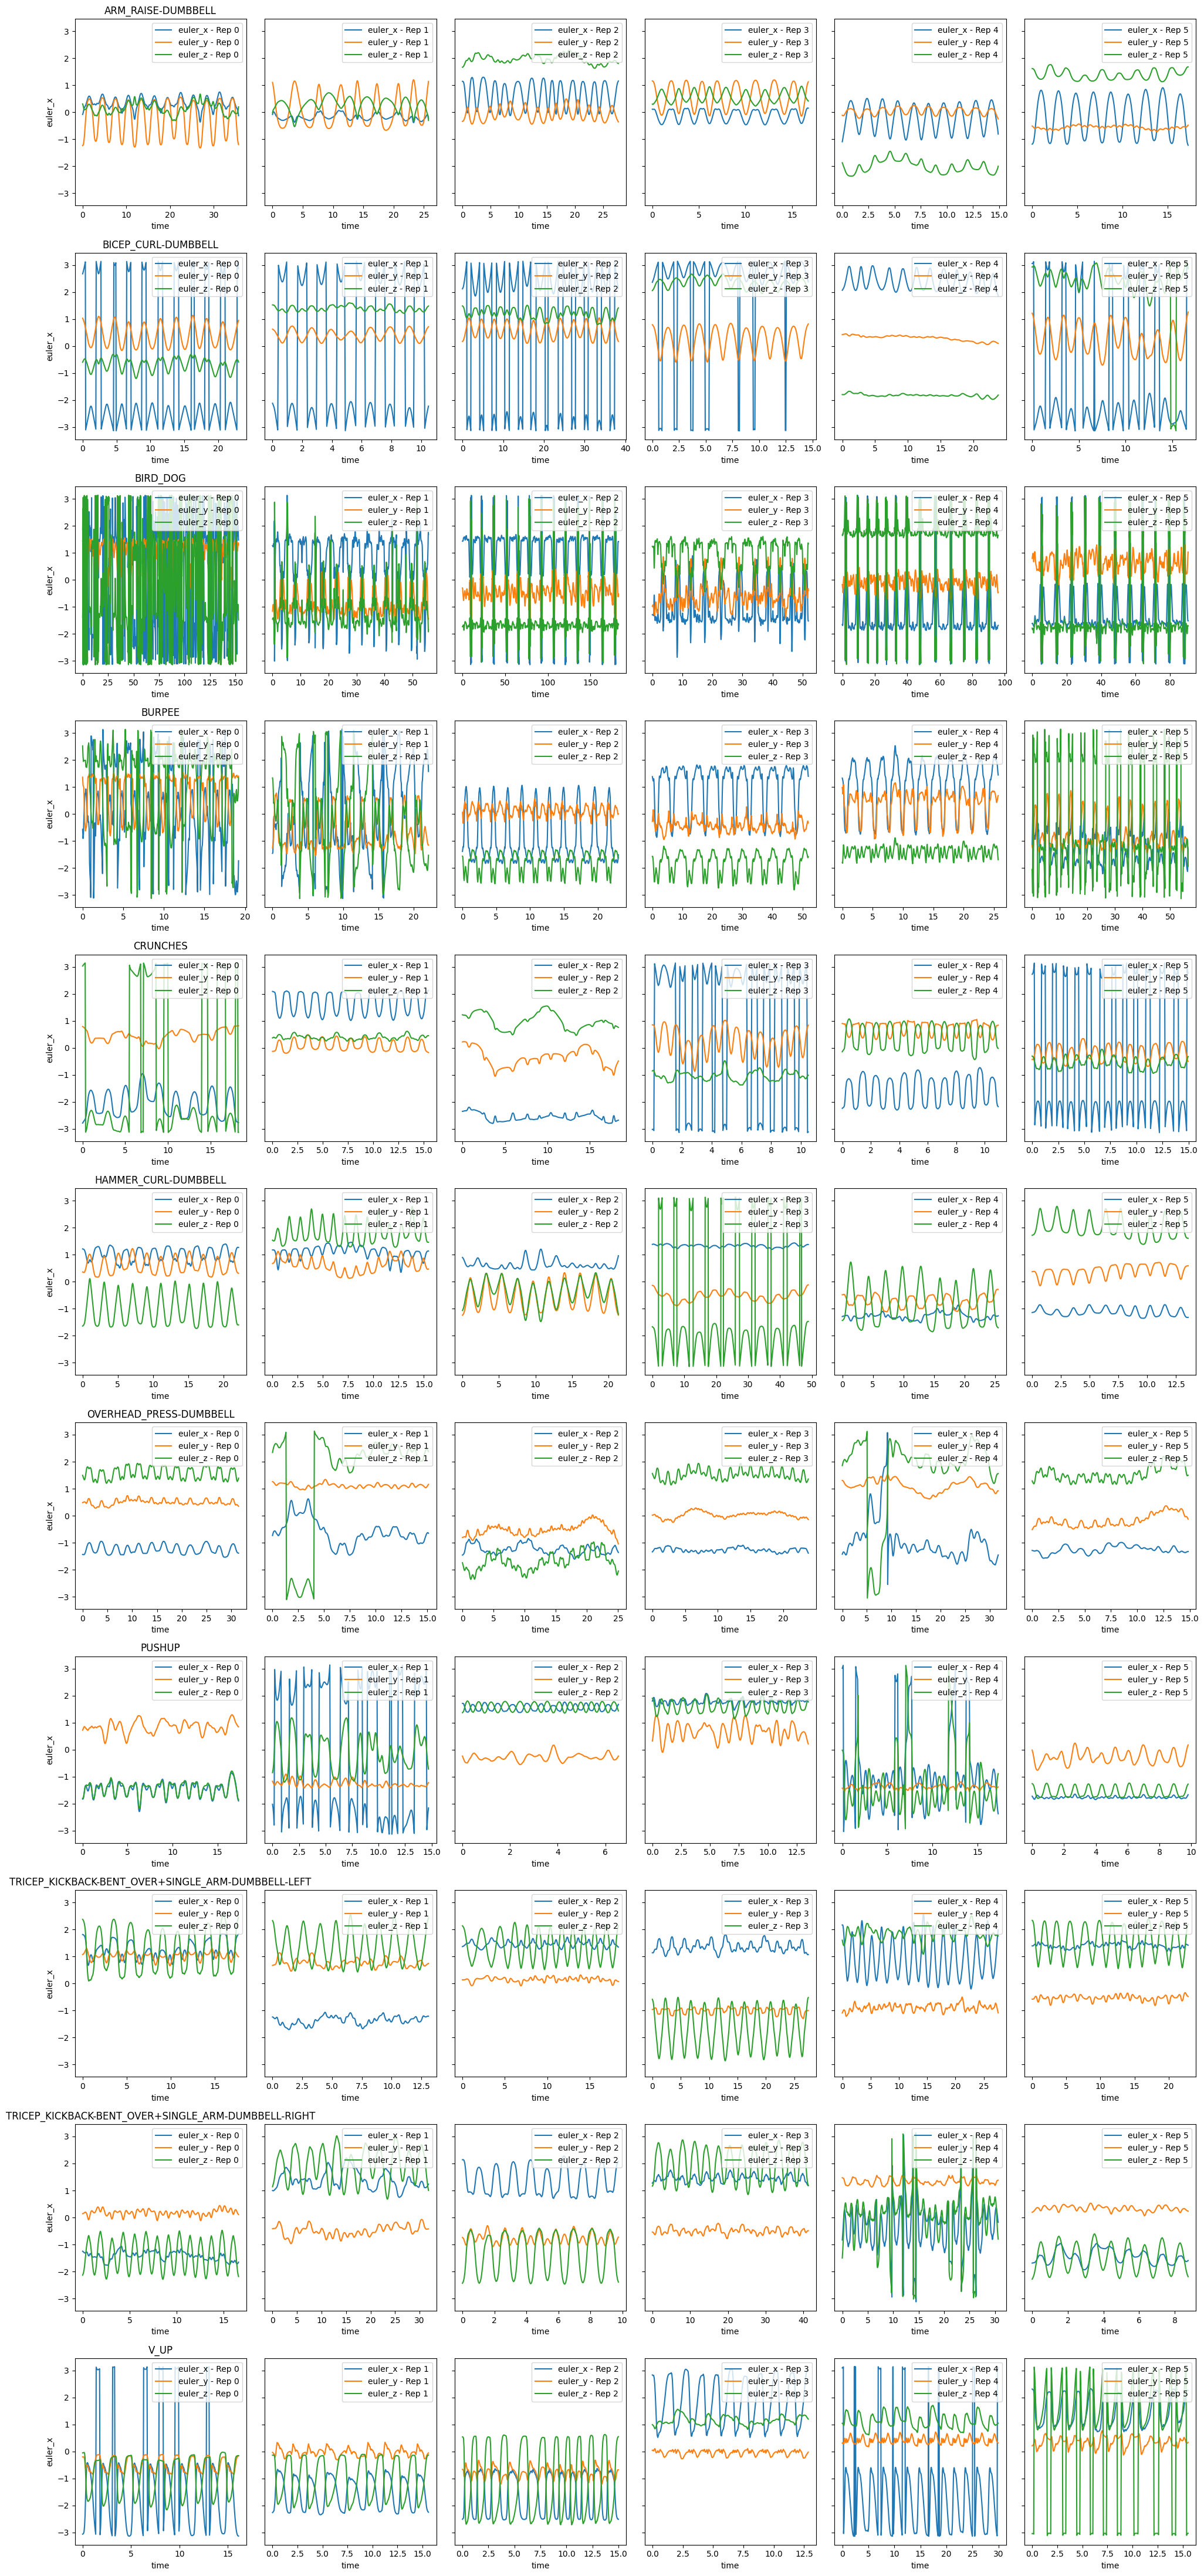

In [51]:
# creating a sampling of plots from each exercise to view the patterns and shapes of the different exercises.

exercise_dataframes = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]

num_plots_per_row = 6
num_rows = 11

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, num_rows * 4), sharey=True)

axes = axes.flatten()

for i, exercise_df_list in enumerate(exercise_dataframes):
    for j, df in enumerate(exercise_df_list[:6]):  # Plot only the first 6 dataframes
        idx = i * num_plots_per_row + j  # Calculate the 1D index
        ax = axes[idx]  # Select the current axis

        # Plot if there is at least one rep_count_from_start less than or equal to 1
        if (df['rep_count_from_start'] <= 1).any():
            # Plot euler_x, euler_y, and euler_z
            sns.lineplot(data=df, x="time", y="euler_x", label=f"euler_x - Rep {j}", ax=ax)
            sns.lineplot(data=df, x="time", y="euler_y", label=f"euler_y - Rep {j}", ax=ax)
            sns.lineplot(data=df, x="time", y="euler_z", label=f"euler_z - Rep {j}", ax=ax)

        if j == 0:  # Add exercise title only on the first plot of every row
            ax.set_title(f'{df.iloc[0]["exercise"]}')

        ax.legend(loc='upper right')  # Add legend in the top right corner

# Hide empty subplots
for i in range(len(exercise_dataframes) * num_plots_per_row, num_rows * num_plots_per_row):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



Each row of plots in the grid above shows a different exercise. When comparing the different exercises you can see both similarites and differences between each set of reps. All measurements supplied are measure from the viewpoint of a smart watch. There are many reasons for the variations in the patterns including the difference in body type of the wearer, the differences in the speed and form of the exercises each subject performs, Where on the wrist is the watch being worn and which wrist it is being worn on?, Is the watch sliding off to one of the wrist or the other? is the watch on backwards?

----

In order to maintain an even amount of data from each set, I will take the smallest number of entries from all the datasets and use that number to take evenly spaced subset from the longer datasets. For the first run \
I used 25 rows, as I thought that was close to my lowest number of rows per rep. I will soon be disappointed that this is not true.

There are 4 exercises containing reps with less than 25 rows each. Crunches, hammercurls, overhead-presses and tricep-kickback-left. I can easily use 10 rows per rep by only eliminating a few data sets from 2 of the exercises, and to 15 by eliminating a few more than that. Before I make that decision I want to take a peek at the plots to see if it makes a drastic different visually.

---

Creating some plots to see how the reduction in data is affecting the overall plots.

In [150]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated.")

#### **Do not run the following lines as the variables are not saved.**

In [61]:
# This function can be used to reduce each rep to s specific number of rows by changing the number in 'interval' and the for loop range()

'''
# function to grab an even selection of values from each exercise rep

def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 10
        entry_list = []

        for i in range(10):
            entry_list.append(round(i * interval))

        df_new = pd.concat([df_new, current_df.iloc[entry_list].copy()], ignore_index=True)

    return df_new
'''

In [58]:
'''
#saving data set with 25 rows per rep
birddog_25 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd25 = birddog_25[50]
'''

In [60]:
'''
#saving data set with 15 rows per rep
birddog_15 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd15 = birddog_15[50]
'''

In [62]:
'''
#saving data set with 10 rows per rep
birddog_10 = [data_reduction_dataframe(df) for df in birddog_dataframes]
bd10 = birddog_10[50]
'''

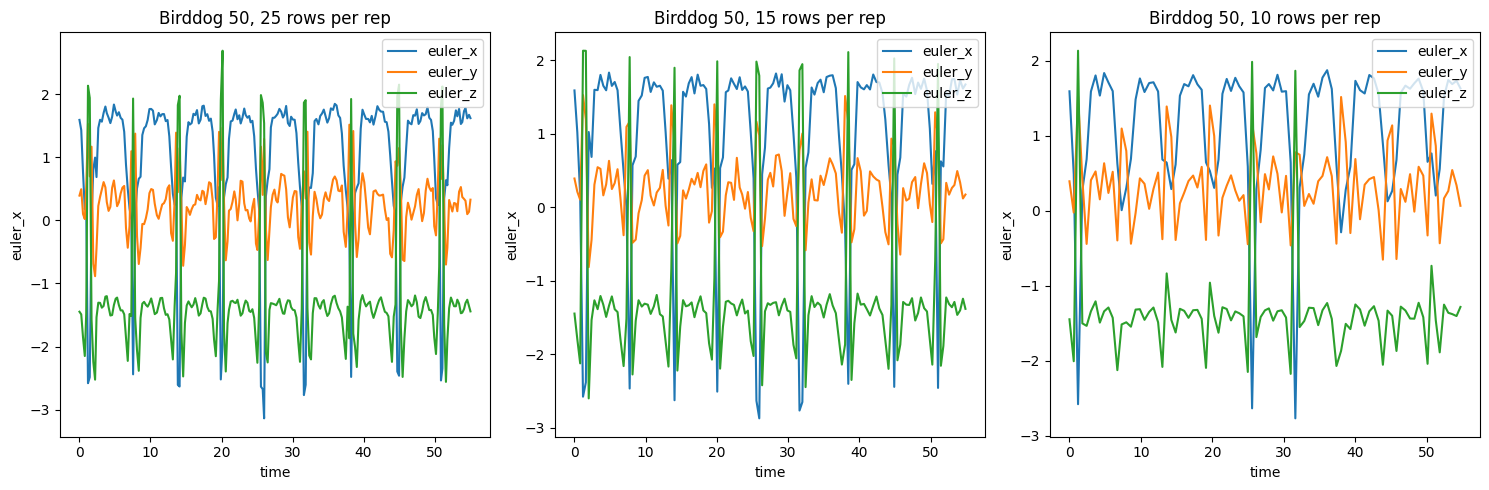

In [64]:
'''
# plotting euler angles birddog 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=bd25, x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=bd25, x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=bd25, x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Birddog 50, 25 rows per rep')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=bd15, x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=bd15, x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=bd15, x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Birddog 50, 15 rows per rep')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=bd10, x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=bd10, x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=bd10, x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Birddog 50, 10 rows per rep')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()
'''

The above plots show what the same exercise set looks like with the inclusion of 25, 15, and 10 rows of data respectively. While there is some detail lost apparent when moving down to 15 rows, there is a huge difference dropping down to 10 rows per rep. For this reason I will try to adjust the number of datasets in order to retain a larger number of rows.

Saving the lists of dataframes before I start reducing the number of rows per rep

In [18]:
# function for saving datasets prior to removing rows
import pickle

def save_dataframes(list_of_dataframe_lists, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(list_of_dataframe_lists, file)

In [19]:
all_lists = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]
file_path = "D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\data_with_euler.pkl"

save_dataframes(all_lists, file_path)


### Load

In [45]:
def load_dataframes(file_path):
    with open("D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\data_with_euler.pkl", 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

In [46]:
loaded_lists = load_dataframes('..\data\pickle\data_with_euler.pkl')

In [49]:
#separating list of data frames by exercise

armraise_dataframes = loaded_lists[0]
bicepcurl_dataframes = loaded_lists[1]
birddog_dataframes = loaded_lists[2]
burpee_dataframes = loaded_lists[3]
crunch_dataframes = loaded_lists[4]
hammercurl_dataframes = loaded_lists[5]
overheadpress_dataframes = loaded_lists[6]
pushup_dataframes = loaded_lists[7]
tricepkickback_left_dataframes = loaded_lists[8]
tricepkickback_right_dataframes = loaded_lists[9]
vup_dataframes = loaded_lists[10]


---

At this point I am going to start taking an even number of rows selected with even spacing from each rep in the dataframes. In order to do this uniformly across all the dataframes I will have to remove a few datasets
that have fewer rows per rep than others. By removing this relatively small number of datasets, I can maintiain more values per rep.

Removing the rows was a bit of a longer process than I planned and so it is not completely shown here. I have shown the function I used to look at the number of rows per rep per dataset and the deletion code for reference. After the reduction process, I reshaped and merged all the individual dataframes into one and saved the file for use without having to do this all over again. 

I have not run the following frame because the output is quite long to show.

In [146]:
# viewing number of rows per rep in each data frame

from collections import defaultdict

row_counts = defaultdict(int)

for idx, df in enumerate(tricepkickback_right_dataframes):
    # Count the number of rows for each repetition
    for rep_num, count in df['rep_num'].value_counts().items():
        row_counts[(idx, rep_num, count)] += 1

# Sort the results by the number of rows
sorted_row_counts = sorted(row_counts.items(), key=lambda x: x[0][2])

print("Repetitions Counted by Number of Rows (Sorted):")
for (df_idx, rep_num, count), repetition_count in sorted_row_counts:
    print(f"DataFrame {df_idx} - Rep Num {rep_num} with {count} rows: {repetition_count} occurrences")

Repetitions Counted by Number of Rows (Sorted):
DataFrame 25 - Rep Num 1 with 14 rows: 1 occurrences
DataFrame 25 - Rep Num 2 with 15 rows: 1 occurrences
DataFrame 25 - Rep Num 6 with 15 rows: 1 occurrences
DataFrame 25 - Rep Num 7 with 15 rows: 1 occurrences
DataFrame 38 - Rep Num 9 with 15 rows: 1 occurrences
DataFrame 72 - Rep Num 8 with 15 rows: 1 occurrences
DataFrame 25 - Rep Num 5 with 16 rows: 1 occurrences
DataFrame 25 - Rep Num 8 with 16 rows: 1 occurrences
DataFrame 25 - Rep Num 13 with 16 rows: 1 occurrences
DataFrame 72 - Rep Num 7 with 16 rows: 1 occurrences
DataFrame 38 - Rep Num 2 with 17 rows: 1 occurrences
DataFrame 38 - Rep Num 3 with 17 rows: 1 occurrences
DataFrame 38 - Rep Num 7 with 17 rows: 1 occurrences
DataFrame 38 - Rep Num 8 with 17 rows: 1 occurrences
DataFrame 42 - Rep Num 7 with 17 rows: 1 occurrences
DataFrame 72 - Rep Num 6 with 17 rows: 1 occurrences
DataFrame 72 - Rep Num 9 with 17 rows: 1 occurrences
DataFrame 72 - Rep Num 14 with 17 rows: 1 occurren

In [144]:
# deleting data sets with limited number of rows per rep
del tricepkickback_right_dataframes[50]


### Save

In [147]:
all_lists = [armraise_dataframes, bicepcurl_dataframes, birddog_dataframes, burpee_dataframes, crunch_dataframes, hammercurl_dataframes, overheadpress_dataframes, pushup_dataframes, tricepkickback_left_dataframes, tricepkickback_right_dataframes, vup_dataframes]
file_path = "D:\Computer Courses\LHL Data Bootcamp\Capstone\Exercise_Recognition\data\pickle\data_with_euler_post_reduction.pkl"

save_dataframes(all_lists, file_path)

---

Selecting rows evenly by rep number

In [148]:
# function to grab 15 evenly spaced rows from each exercise rep

def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 15
        entry_list = []

        for i in range(15):
            entry_list.append(round(i * interval))

        df_new = pd.concat([df_new, current_df.iloc[entry_list].copy()], ignore_index=True)

    return df_new

In [152]:
def data_reduction_dataframe(df):
    df_new = pd.DataFrame(columns=df.columns)

    for rep in range(df['rep_num'].astype(int).max()):
        current_df = df[df['rep_num'] == rep + 1]
        count = current_df.shape[0]
        interval = count / 15
        entry_list = []

        for i in range(15):
            entry_list.append(round(i * interval))

        current_df_reduced = current_df.iloc[entry_list].copy()

        # Exclude empty or all-NA columns
        non_empty_columns = current_df_reduced.columns[~current_df_reduced.isna().all()]

        if len(non_empty_columns) > 0:
            current_df_reduced = current_df_reduced[non_empty_columns]
            df_new = pd.concat([df_new, current_df_reduced], ignore_index=True)

    return df_new


In [153]:
# calling above function for each list of dataframes

armraise_reduced = [data_reduction_dataframe(df) for df in armraise_dataframes] #
bicepcurl_reduced = [data_reduction_dataframe(df) for df in bicepcurl_dataframes]
birddog_reduced = [data_reduction_dataframe(df) for df in birddog_dataframes]
burpee_reduced = [data_reduction_dataframe(df) for df in burpee_dataframes]
crunch_reduced = [data_reduction_dataframe(df) for df in crunch_dataframes] #
hammercurl_reduced = [data_reduction_dataframe(df) for df in hammercurl_dataframes] 
overheadpress_reduced = [data_reduction_dataframe(df) for df in overheadpress_dataframes] #
pushup_reduced = [data_reduction_dataframe(df) for df in pushup_dataframes] #
tricepkickback_left_reduced = [data_reduction_dataframe(df) for df in tricepkickback_left_dataframes] #
tricepkickback_right_reduced = [data_reduction_dataframe(df) for df in tricepkickback_right_dataframes]
vup_reduced = [data_reduction_dataframe(df) for df in vup_dataframes]

In [154]:
len(tricepkickback_right_reduced[0])

210

In [155]:
# print the rows for the dataframe with the lowest number of rows. 

sorted_dataframes = sorted(enumerate(vup_reduced), key=lambda x: x[1].shape[0])

for i, (index, df) in enumerate(sorted_dataframes[:1]):
    print(f"DataFrame {index}: {df.shape[0]} rows")

DataFrame 18: 120 rows


The lowest number of rows in each grouping is 120, So I will reduce all of the datasets to 120 rows, which will leave 8 reps per dataset.

In [156]:
# function to reduce the dataframes to 120 rows

def reduce_dataframes_to_120_rows(dataframes_list):
    reduced_dataframes = [df.head(120) for df in dataframes_list]
    return reduced_dataframes

In [157]:
# reducing all dataframes to 120 rows

armraise_final = reduce_dataframes_to_120_rows(armraise_reduced)
bicepcurl_final = reduce_dataframes_to_120_rows(bicepcurl_reduced)
birddog_final = reduce_dataframes_to_120_rows(birddog_reduced)
burpee_final = reduce_dataframes_to_120_rows(burpee_reduced)
crunch_final = reduce_dataframes_to_120_rows(crunch_reduced)
hammercurl_final = reduce_dataframes_to_120_rows(hammercurl_reduced)
overheadpress_final = reduce_dataframes_to_120_rows(overheadpress_reduced)
pushup_final = reduce_dataframes_to_120_rows(pushup_reduced)
tricepkickback_left_final = reduce_dataframes_to_120_rows(tricepkickback_left_reduced)
tricepkickback_right_final = reduce_dataframes_to_120_rows(tricepkickback_right_reduced)
vup_final = reduce_dataframes_to_120_rows(vup_reduced)

Now I need to reshape all of the dataframes so I can merge them all into one dataframe that I can apply some models to.

In [158]:
# function to flatten the data frames into single rows and them merge them. Each row containing the data from 1 set of 8 reps

def process_dataframes(dataframes):
    result_df_list = []

    for df in dataframes:
        euler_columns = df[['euler_x', 'euler_y', 'euler_z']].values.flatten()
        new_df = pd.DataFrame([euler_columns], columns=[f"euler_{axis}_{i}" for i in range(1, len(euler_columns)//3 + 1) for axis in ['x', 'y', 'z']])
        first_row = df.iloc[0, :].drop(['euler_x', 'euler_y', 'euler_z'])

        result_df = pd.concat([first_row.to_frame().T, new_df], axis=1)
        result_df_list.append(result_df)

    final_result_df = pd.concat(result_df_list, ignore_index=True)
    return final_result_df

In [159]:
# calling the above function

armraise = process_dataframes(armraise_final)
bicepcurl = process_dataframes(bicepcurl_final)
birddog = process_dataframes(birddog_final)
burpee = process_dataframes(burpee_final)
crunch = process_dataframes(crunch_final)
hammercurl = process_dataframes(hammercurl_final)
overheadpress = process_dataframes(overheadpress_final)
tricepkickback_left = process_dataframes(tricepkickback_left_final)
tricepkickback_right = process_dataframes(tricepkickback_right_final)
vup = process_dataframes(vup_final)

In [160]:
tricepkickback_left.shape

(98, 384)

In [161]:
# final merge to create a dataframe with all the exercises

exercise_df = pd.concat([armraise, bicepcurl, birddog, burpee, crunch, hammercurl, overheadpress, tricepkickback_left, tricepkickback_right, vup], ignore_index=True)


In [162]:
exercise_df

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,time,rep_num,avg_rep_time,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4,euler_x_5,euler_y_5,euler_z_5,euler_x_6,euler_y_6,euler_z_6,euler_x_7,euler_y_7,euler_z_7,euler_x_8,euler_y_8,euler_z_8,euler_x_9,euler_y_9,euler_z_9,euler_x_10,euler_y_10,euler_z_10,euler_x_11,euler_y_11,euler_z_11,euler_x_12,euler_y_12,euler_z_12,euler_x_13,euler_y_13,euler_z_13,euler_x_14,euler_y_14,euler_z_14,euler_x_15,euler_y_15,euler_z_15,euler_x_16,euler_y_16,euler_z_16,euler_x_17,euler_y_17,euler_z_17,euler_x_18,euler_y_18,euler_z_18,euler_x_19,euler_y_19,euler_z_19,euler_x_20,euler_y_20,euler_z_20,euler_x_21,euler_y_21,euler_z_21,euler_x_22,euler_y_22,euler_z_22,euler_x_23,euler_y_23,euler_z_23,euler_x_24,euler_y_24,euler_z_24,euler_x_25,euler_y_25,euler_z_25,euler_x_26,euler_y_26,euler_z_26,euler_x_27,euler_y_27,euler_z_27,euler_x_28,euler_y_28,euler_z_28,euler_x_29,euler_y_29,euler_z_29,euler_x_30,euler_y_30,euler_z_30,euler_x_31,euler_y_31,euler_z_31,euler_x_32,euler_y_32,euler_z_32,euler_x_33,euler_y_33,euler_z_33,euler_x_34,euler_y_34,euler_z_34,euler_x_35,euler_y_35,euler_z_35,euler_x_36,euler_y_36,euler_z_36,euler_x_37,euler_y_37,euler_z_37,euler_x_38,euler_y_38,euler_z_38,euler_x_39,euler_y_39,euler_z_39,euler_x_40,euler_y_40,euler_z_40,euler_x_41,euler_y_41,euler_z_41,euler_x_42,euler_y_42,euler_z_42,euler_x_43,euler_y_43,euler_z_43,euler_x_44,euler_y_44,euler_z_44,euler_x_45,euler_y_45,euler_z_45,euler_x_46,euler_y_46,euler_z_46,euler_x_47,euler_y_47,euler_z_47,euler_x_48,euler_y_48,euler_z_48,euler_x_49,euler_y_49,euler_z_49,euler_x_50,euler_y_50,euler_z_50,euler_x_51,euler_y_51,euler_z_51,euler_x_52,euler_y_52,euler_z_52,euler_x_53,euler_y_53,euler_z_53,euler_x_54,euler_y_54,euler_z_54,euler_x_55,euler_y_55,euler_z_55,euler_x_56,euler_y_56,euler_z_56,euler_x_57,euler_y_57,euler_z_57,euler_x_58,euler_y_58,euler_z_58,euler_x_59,euler_y_59,euler_z_59,euler_x_60,euler_y_60,euler_z_60,euler_x_61,euler_y_61,euler_z_61,euler_x_62,euler_y_62,euler_z_62,euler_x_63,euler_y_63,euler_z_63,euler_x_64,euler_y_64,euler_z_64,euler_x_65,euler_y_65,euler_z_65,euler_x_66,euler_y_66,euler_z_66,euler_x_67,euler_y_67,euler_z_67,euler_x_68,euler_y_68,euler_z_68,euler_x_69,euler_y_69,euler_z_69,euler_x_70,euler_y_70,euler_z_70,euler_x_71,euler_y_71,euler_z_71,euler_x_72,euler_y_72,euler_z_72,euler_x_73,euler_y_73,euler_z_73,euler_x_74,euler_y_74,euler_z_74,euler_x_75,euler_y_75,euler_z_75,euler_x_76,euler_y_76,euler_z_76,euler_x_77,euler_y_77,euler_z_77,euler_x_78,euler_y_78,euler_z_78,euler_x_79,euler_y_79,euler_z_79,euler_x_80,euler_y_80,euler_z_80,euler_x_81,euler_y_81,euler_z_81,euler_x_82,euler_y_82,euler_z_82,euler_x_83,euler_y_83,euler_z_83,euler_x_84,euler_y_84,euler_z_84,euler_x_85,euler_y_85,euler_z_85,euler_x_86,euler_y_86,euler_z_86,euler_x_87,euler_y_87,euler_z_87,euler_x_88,euler_y_88,euler_z_88,euler_x_89,euler_y_89,euler_z_89,euler_x_90,euler_y_90,euler_z_90,euler_x_91,euler_y_91,euler_z_91,euler_x_92,euler_y_92,euler_z_92,euler_x_93,euler_y_93,euler_z_93,euler_x_94,euler_y_94,euler_z_94,euler_x_95,euler_y_95,euler_z_95,euler_x_96,euler_y_96,euler_z_96,euler_x_97,euler_y_97,euler_z_97,euler_x_98,euler_y_98,euler_z_98,euler_x_99,euler_y_99,euler_z_99,euler_x_100,euler_y_100,euler_z_100,euler_x_101,euler_y_101,euler_z_101,euler_x_102,euler_y_102,euler_z_102,euler_x_103,euler_y_103,euler_z_103,euler_x_104,euler_y_104,euler_z_104,euler_x_105,euler_y_105,euler_z_105,euler_x_106,euler_y_106,euler_z_106,euler_x_107,euler_y_107,euler_z_107,euler_x_108,euler_y_108,euler_z_108,euler_x_109,euler_y_109,euler_z_109,euler_x_110,euler_y

----

#### Save

In [163]:
# saving dataframe before removing columns

exercise_df.to_csv('../data/csvs/exercise_df_all_columns.csv', index=False)

#### Load

In [164]:
exercise_df = pd.read_csv('../data/csvs/exercise_df_all_columns.csv')

---

Now that I have all my data in one place in a format I can use, its time to clean up the columns a little bit.

In [165]:
exercise_df['rep_num'].unique()

array([1], dtype=int64)

In [166]:
exercise_df.shape

(1766, 384)

In [167]:
exercise_df.head(1)

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,time,rep_num,avg_rep_time,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4,euler_x_5,euler_y_5,euler_z_5,euler_x_6,euler_y_6,euler_z_6,euler_x_7,euler_y_7,euler_z_7,euler_x_8,euler_y_8,euler_z_8,euler_x_9,euler_y_9,euler_z_9,euler_x_10,euler_y_10,euler_z_10,euler_x_11,euler_y_11,euler_z_11,euler_x_12,euler_y_12,euler_z_12,euler_x_13,euler_y_13,euler_z_13,euler_x_14,euler_y_14,euler_z_14,euler_x_15,euler_y_15,euler_z_15,euler_x_16,euler_y_16,euler_z_16,euler_x_17,euler_y_17,euler_z_17,euler_x_18,euler_y_18,euler_z_18,euler_x_19,euler_y_19,euler_z_19,euler_x_20,euler_y_20,euler_z_20,euler_x_21,euler_y_21,euler_z_21,euler_x_22,euler_y_22,euler_z_22,euler_x_23,euler_y_23,euler_z_23,euler_x_24,euler_y_24,euler_z_24,euler_x_25,euler_y_25,euler_z_25,euler_x_26,euler_y_26,euler_z_26,euler_x_27,euler_y_27,euler_z_27,euler_x_28,euler_y_28,euler_z_28,euler_x_29,euler_y_29,euler_z_29,euler_x_30,euler_y_30,euler_z_30,euler_x_31,euler_y_31,euler_z_31,euler_x_32,euler_y_32,euler_z_32,euler_x_33,euler_y_33,euler_z_33,euler_x_34,euler_y_34,euler_z_34,euler_x_35,euler_y_35,euler_z_35,euler_x_36,euler_y_36,euler_z_36,euler_x_37,euler_y_37,euler_z_37,euler_x_38,euler_y_38,euler_z_38,euler_x_39,euler_y_39,euler_z_39,euler_x_40,euler_y_40,euler_z_40,euler_x_41,euler_y_41,euler_z_41,euler_x_42,euler_y_42,euler_z_42,euler_x_43,euler_y_43,euler_z_43,euler_x_44,euler_y_44,euler_z_44,euler_x_45,euler_y_45,euler_z_45,euler_x_46,euler_y_46,euler_z_46,euler_x_47,euler_y_47,euler_z_47,euler_x_48,euler_y_48,euler_z_48,euler_x_49,euler_y_49,euler_z_49,euler_x_50,euler_y_50,euler_z_50,euler_x_51,euler_y_51,euler_z_51,euler_x_52,euler_y_52,euler_z_52,euler_x_53,euler_y_53,euler_z_53,euler_x_54,euler_y_54,euler_z_54,euler_x_55,euler_y_55,euler_z_55,euler_x_56,euler_y_56,euler_z_56,euler_x_57,euler_y_57,euler_z_57,euler_x_58,euler_y_58,euler_z_58,euler_x_59,euler_y_59,euler_z_59,euler_x_60,euler_y_60,euler_z_60,euler_x_61,euler_y_61,euler_z_61,euler_x_62,euler_y_62,euler_z_62,euler_x_63,euler_y_63,euler_z_63,euler_x_64,euler_y_64,euler_z_64,euler_x_65,euler_y_65,euler_z_65,euler_x_66,euler_y_66,euler_z_66,euler_x_67,euler_y_67,euler_z_67,euler_x_68,euler_y_68,euler_z_68,euler_x_69,euler_y_69,euler_z_69,euler_x_70,euler_y_70,euler_z_70,euler_x_71,euler_y_71,euler_z_71,euler_x_72,euler_y_72,euler_z_72,euler_x_73,euler_y_73,euler_z_73,euler_x_74,euler_y_74,euler_z_74,euler_x_75,euler_y_75,euler_z_75,euler_x_76,euler_y_76,euler_z_76,euler_x_77,euler_y_77,euler_z_77,euler_x_78,euler_y_78,euler_z_78,euler_x_79,euler_y_79,euler_z_79,euler_x_80,euler_y_80,euler_z_80,euler_x_81,euler_y_81,euler_z_81,euler_x_82,euler_y_82,euler_z_82,euler_x_83,euler_y_83,euler_z_83,euler_x_84,euler_y_84,euler_z_84,euler_x_85,euler_y_85,euler_z_85,euler_x_86,euler_y_86,euler_z_86,euler_x_87,euler_y_87,euler_z_87,euler_x_88,euler_y_88,euler_z_88,euler_x_89,euler_y_89,euler_z_89,euler_x_90,euler_y_90,euler_z_90,euler_x_91,euler_y_91,euler_z_91,euler_x_92,euler_y_92,euler_z_92,euler_x_93,euler_y_93,euler_z_93,euler_x_94,euler_y_94,euler_z_94,euler_x_95,euler_y_95,euler_z_95,euler_x_96,euler_y_96,euler_z_96,euler_x_97,euler_y_97,euler_z_97,euler_x_98,euler_y_98,euler_z_98,euler_x_99,euler_y_99,euler_z_99,euler_x_100,euler_y_100,euler_z_100,euler_x_101,euler_y_101,euler_z_101,euler_x_102,euler_y_102,euler_z_102,euler_x_103,euler_y_103,euler_z_103,euler_x_104,euler_y_104,euler_z_104,euler_x_105,euler_y_105,euler_z_105,euler_x_106,euler_y_106,euler_z_106,euler_x_107,euler_y_107,euler_z_107,euler_x_108,euler_y_108,euler_z_108,euler_x_109,euler_y_109,euler_z_109,euler_x_110,euler_y

In [169]:
# dropping unnecessary columns
columns_to_drop = ['num_reps', 'trim_start_frac', 'trim_end_frac', 'kinematic_noise_factor', 'use_random_motion', 'randomize_body_shape', 'frames_per_second', 'image_width', 'image_height', 'seconds_per_rep', 'num_random_frames', 'rep_count_from_intermediate', 'rep_count_from_start', 'time', 'rep_num', 'random_seed']
exercise_df=exercise_df.drop(columns = columns_to_drop)

In [170]:
exercise_df.shape

(1766, 368)

In [171]:
exercise_df.head(1)

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,avg_rep_time,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4,euler_x_5,euler_y_5,euler_z_5,euler_x_6,euler_y_6,euler_z_6,euler_x_7,euler_y_7,euler_z_7,euler_x_8,euler_y_8,euler_z_8,euler_x_9,euler_y_9,euler_z_9,euler_x_10,euler_y_10,euler_z_10,euler_x_11,euler_y_11,euler_z_11,euler_x_12,euler_y_12,euler_z_12,euler_x_13,euler_y_13,euler_z_13,euler_x_14,euler_y_14,euler_z_14,euler_x_15,euler_y_15,euler_z_15,euler_x_16,euler_y_16,euler_z_16,euler_x_17,euler_y_17,euler_z_17,euler_x_18,euler_y_18,euler_z_18,euler_x_19,euler_y_19,euler_z_19,euler_x_20,euler_y_20,euler_z_20,euler_x_21,euler_y_21,euler_z_21,euler_x_22,euler_y_22,euler_z_22,euler_x_23,euler_y_23,euler_z_23,euler_x_24,euler_y_24,euler_z_24,euler_x_25,euler_y_25,euler_z_25,euler_x_26,euler_y_26,euler_z_26,euler_x_27,euler_y_27,euler_z_27,euler_x_28,euler_y_28,euler_z_28,euler_x_29,euler_y_29,euler_z_29,euler_x_30,euler_y_30,euler_z_30,euler_x_31,euler_y_31,euler_z_31,euler_x_32,euler_y_32,euler_z_32,euler_x_33,euler_y_33,euler_z_33,euler_x_34,euler_y_34,euler_z_34,euler_x_35,euler_y_35,euler_z_35,euler_x_36,euler_y_36,euler_z_36,euler_x_37,euler_y_37,euler_z_37,euler_x_38,euler_y_38,euler_z_38,euler_x_39,euler_y_39,euler_z_39,euler_x_40,euler_y_40,euler_z_40,euler_x_41,euler_y_41,euler_z_41,euler_x_42,euler_y_42,euler_z_42,euler_x_43,euler_y_43,euler_z_43,euler_x_44,euler_y_44,euler_z_44,euler_x_45,euler_y_45,euler_z_45,euler_x_46,euler_y_46,euler_z_46,euler_x_47,euler_y_47,euler_z_47,euler_x_48,euler_y_48,euler_z_48,euler_x_49,euler_y_49,euler_z_49,euler_x_50,euler_y_50,euler_z_50,euler_x_51,euler_y_51,euler_z_51,euler_x_52,euler_y_52,euler_z_52,euler_x_53,euler_y_53,euler_z_53,euler_x_54,euler_y_54,euler_z_54,euler_x_55,euler_y_55,euler_z_55,euler_x_56,euler_y_56,euler_z_56,euler_x_57,euler_y_57,euler_z_57,euler_x_58,euler_y_58,euler_z_58,euler_x_59,euler_y_59,euler_z_59,euler_x_60,euler_y_60,euler_z_60,euler_x_61,euler_y_61,euler_z_61,euler_x_62,euler_y_62,euler_z_62,euler_x_63,euler_y_63,euler_z_63,euler_x_64,euler_y_64,euler_z_64,euler_x_65,euler_y_65,euler_z_65,euler_x_66,euler_y_66,euler_z_66,euler_x_67,euler_y_67,euler_z_67,euler_x_68,euler_y_68,euler_z_68,euler_x_69,euler_y_69,euler_z_69,euler_x_70,euler_y_70,euler_z_70,euler_x_71,euler_y_71,euler_z_71,euler_x_72,euler_y_72,euler_z_72,euler_x_73,euler_y_73,euler_z_73,euler_x_74,euler_y_74,euler_z_74,euler_x_75,euler_y_75,euler_z_75,euler_x_76,euler_y_76,euler_z_76,euler_x_77,euler_y_77,euler_z_77,euler_x_78,euler_y_78,euler_z_78,euler_x_79,euler_y_79,euler_z_79,euler_x_80,euler_y_80,euler_z_80,euler_x_81,euler_y_81,euler_z_81,euler_x_82,euler_y_82,euler_z_82,euler_x_83,euler_y_83,euler_z_83,euler_x_84,euler_y_84,euler_z_84,euler_x_85,euler_y_85,euler_z_85,euler_x_86,euler_y_86,euler_z_86,euler_x_87,euler_y_87,euler_z_87,euler_x_88,euler_y_88,euler_z_88,euler_x_89,euler_y_89,euler_z_89,euler_x_90,euler_y_90,euler_z_90,euler_x_91,euler_y_91,euler_z_91,euler_x_92,euler_y_92,euler_z_92,euler_x_93,euler_y_93,euler_z_93,euler_x_94,euler_y_94,euler_z_94,euler_x_95,euler_y_95,euler_z_95,euler_x_96,euler_y_96,euler_z_96,euler_x_97,euler_y_97,euler_z_97,euler_x_98,euler_y_98,euler_z_98,euler_x_99,euler_y_99,euler_z_99,euler_x_100,euler_y_100,euler_z_100,euler_x_101,euler_y_101,euler_z_101,euler_x_102,euler_y_102,euler_z_102,euler_x_103,euler_y_103,euler_z_103,euler_x_104,euler_y_104,euler_z_104,euler_x_105,euler_y_105,euler_z_105,euler_x_106,euler_y_106,euler_z_106,euler_x_107,euler_y_107,euler_z_107,euler_x_108,euler_y_108,euler_z_108,euler_x_109,euler_y_109,euler_z_109,euler_x_110,euler_y_110,euler_z_110,euler_x_111,euler_y_111,euler_z_111,euler_x_112,euler_y_112,euler_z_112,euler_x_113,euler_y_113,euler_z_113,euler_x_114,euler_y_114,euler_z_114,euler_x_115,euler_y_115,euler_z_115,euler_x_116,euler_y_116,euler_z_116,euler_x_117,euler_y

In [172]:
# viewing the categorical columns that will require some encoding prior to modelling

non_numeric_columns = exercise_df.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

Index(['exercise', 'watch_location', 'crown_orientation'], dtype='object')


#### Save

In [173]:
# saving dataframe before removing columns

exercise_df.to_csv('../data/csvs/exercise_df_pre_modelling.csv', index=False)

---

In this section I was attempting to learn about Fourier Transform as I thought that it may have helped me in getting my data set up and simplified prior to modelling. I'm going to leave this here, as I spent a significant amount of time reading and learning about this subject. However, I can't claim that I understand it completely and I don't think I'll be using it further into this project.

## Learning about Fourier Transform

https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/ \
https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101

In [174]:
from scipy.fft import fft

# Apply Fourier transform to the columns containing euler angles

df2 = armraise_dataframes[0]
euler_columns = ['euler_x', 'euler_y', 'euler_z']

for col in euler_columns:
    euler_array = np.ascontiguousarray(df2[col].values)
    
    df2[f'{col}_fft'] = np.abs(fft(euler_array))


In [175]:
df2.head()

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,time,rep_num,avg_rep_time,euler_x,euler_y,euler_z,euler_x_fft,euler_y_fft,euler_z_fft
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,0.00,1,2.970833,-0.085816,-1.236302,0.301816,233.448722,164.943182,104.794592
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,0.05,1,2.970833,-0.068092,-1.232152,0.282132,0.427206,5.311859,17.004060
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,0.10,1,2.970833,-0.038189,-1.221286,0.252032,11.860372,21.937540,60.676702
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.523469,0.049785,0.15,1,2.970833,-0.001822,-1.203772,0.216632,0.547906,14.878555,56.158340
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.540063,0.066379,0.20,1,2.970833,0.042375,-1.174680,0.175925,28.460837,16.318868,17.178685


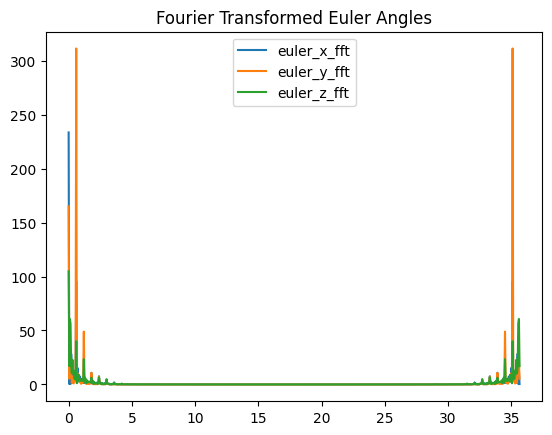

In [176]:
# Plotting each Fourier-transformed column

euler_fft_columns = ['euler_x_fft', 'euler_y_fft', 'euler_z_fft']

for col in euler_fft_columns:
    plt.plot(df2['time'], df2[col], label=col)

plt.legend()
plt.title('Fourier Transformed Euler Angles')
plt.show()

.